<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=170 style="padding: 10px"> 
<b>Little Demo: Light curves of cool dwarfs</b> <br>
Contact author(s): Jeff Carlin and Yumi Choi<br>
Last verified to run: 2024-01-19 <br>
LSST Science Pipelines version: Weekly 2023_47 <br>
Container Size: medium

Let's plot a light curve of a color-selected (red) cool dwarf star to see if it shows any variability. This is a truncated version of the DP0.2 tutorial notebook 07b, "Variable Stars in DP0.2".

## 1. Setup and Package Imports

In [1]:
# General
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

# LSST package for TAP queries
from lsst.rsp import get_tap_service

Set up some plotting defaults so plots will look nice:

In [2]:
%matplotlib inline

params = {'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 12,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [10, 8],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

plot_filter_labels = ['u', 'g', 'r', 'i', 'z', 'y']
plot_filter_colors = {'u': '#56b4e9', 'g': '#008060', 'r': '#ff4000',
                      'i': '#850000', 'z': '#6600cc', 'y': '#000000'}
plot_filter_symbols = {'u': 'o', 'g': '^', 'r': 'v', 'i': 's', 'z': '*', 'y': 'p'}

Start the TAP service, which we will use for all data retrieval in this notebook:

In [3]:
service = get_tap_service("tap")

## 2. Create a Lightcurve for a "Very Red" Star

Find objects (from the `Object` table) in a 2-degree search region with very red colors in (i-z) and (z-y). Also require them to be point-like ("extendedness = 0") and have signal-to-noise > 5.

In [4]:
query = "SELECT objectId, " + \
        "scisql_nanojanskyToAbMag(i_psfFlux) as imag, " + \
        "scisql_nanojanskyToAbMag(z_psfFlux) as zmag, " + \
        "scisql_nanojanskyToAbMag(y_psfFlux) as ymag " + \
        "FROM dp02_dc2_catalogs.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), " + \
        "CIRCLE('ICRS', 55.75, -32.27, 2.0)) = 1 " + \
        "AND detect_isPrimary = 1 " + \
        "AND i_extendedness = 0 AND z_extendedness = 0 " + \
        "AND i_psfFlux/i_psfFluxErr > 5 " + \
        "AND z_psfFlux/z_psfFluxErr > 5 " + \
        "AND y_psfFlux/y_psfFluxErr > 5 " + \
        "AND scisql_nanojanskyToAbMag(i_psfFlux)-scisql_nanojanskyToAbMag(z_psfFlux) > 1.0 " + \
        "AND scisql_nanojanskyToAbMag(z_psfFlux)-scisql_nanojanskyToAbMag(y_psfFlux) > 1.0 "

results = service.search(query)
objects = results.to_table()


In [5]:
objects.sort('zmag')
objects

objectId,imag,zmag,ymag
int64,float64,float64,float64
1909992434935276462,22.47937198654143,21.082419777240034,19.90635729215792
1910616957539848846,22.74561741976364,21.330553138142378,20.15615908058814
1910265113818958967,23.14515569878916,21.76277839431919,20.581923005490864
1822093077364352264,23.558847220122736,22.149709614977674,20.964945103433756
1910045211493449980,23.95774299360061,22.431506779388844,21.296658687696677
1822532882015498892,24.02120334593114,22.65375341041908,21.528333767759797
1821574107876042279,24.11446140820055,22.686525644065245,21.524524993183228
1909579018563253617,24.412838918542683,22.709110597788065,21.17597187473248
1910141968516681274,24.10476297607191,22.71463968489497,21.547281572454843


Select the object ID of the brightest star returned by our color-limited search of the `Object` table, and run a search to get the forced source photometry.

In [6]:
sel_objid = objects[0]['objectId']

# Define the query
query = "SELECT src.band, src.ccdVisitId, src.coord_ra, src.coord_dec, "\
        "src.objectId, src.psfFlux, src.psfFluxErr, "\
        "scisql_nanojanskyToAbMag(psfFlux) as psfMag, "\
        "scisql_nanojanskyToAbMagSigma(psfFlux, psfFluxErr) as psfMagErr, "\
        "visinfo.ccdVisitId, visinfo.band, "\
        "visinfo.expMidptMJD, visinfo.zeroPoint "\
        "FROM dp02_dc2_catalogs.ForcedSource as src "\
        "JOIN dp02_dc2_catalogs.CcdVisit as visinfo "\
        "ON visinfo.ccdVisitId = src.ccdVisitId "\
        "WHERE src.objectId = "+str(sel_objid)+" "

results = service.search(query)
srcs = results.to_table()
del query


Uncomment and execute the following cell to see what this table looks like.

In [7]:
#srcs

Plot the lightcurve of the star in the three reddest (izy) filters.

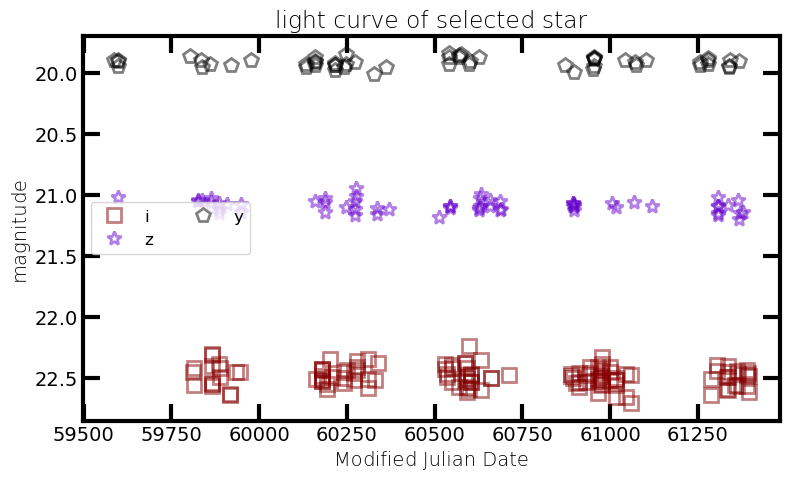

In [8]:
pick = {}
for filter in plot_filter_labels[-3:]:
    pick[filter] = (srcs['band'] == filter)

fig, ax = plt.subplots(figsize=(9, 5))
    
for filter in plot_filter_labels[-3:]:
    ax.plot(srcs[pick[filter]]['expMidptMJD'], srcs[pick[filter]]['psfMag'],
    plot_filter_symbols[filter], ms=10, mew=2, mec=plot_filter_colors[filter],
    alpha=0.5, color='none', label=filter)

ax.set_xlabel('Modified Julian Date')
ax.set_ylabel('magnitude')
ax.set_title('light curve of selected star')
ax.legend(loc='center left', ncol=2)
ax.invert_yaxis()

plt.show()

Plot the lightcurve of the star in a single band with the median magnitude removed, including error bars on each measurement.

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


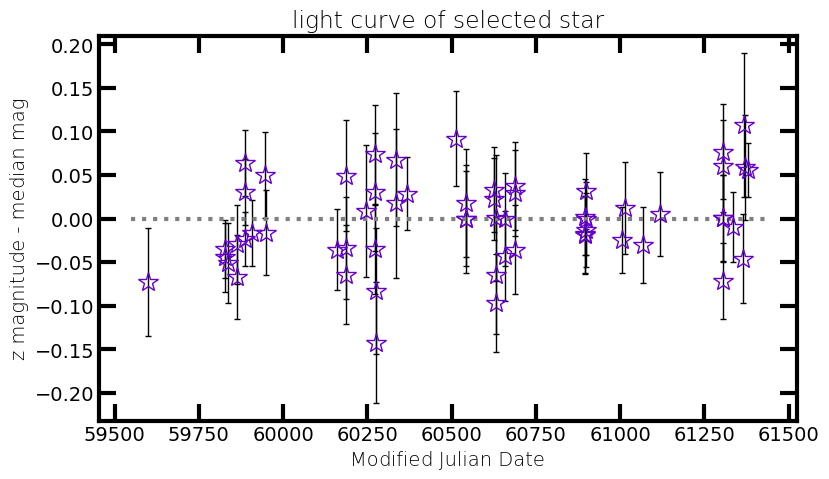

In [9]:
plt.figure(figsize=(9, 5))
    
for filter in ['z']:
    plt.errorbar(srcs[pick[filter]]['expMidptMJD'],
                 srcs[pick[filter]]['psfMag']-np.median(srcs[pick[filter]]['psfMag']),
                 yerr=srcs[pick[filter]]['psfMagErr'],
                 fmt=plot_filter_symbols[filter], ecolor='black', elinewidth=1, capsize=2,
                 ms=15, mew=1, mec=plot_filter_colors[filter],
                 alpha=1, color='none', label=filter)
    plt.hlines(0, np.min(srcs[pick[filter]]['expMidptMJD'])-50, np.max(srcs[pick[filter]]['expMidptMJD'])+50,
               linestyle=':', color='Gray')

plt.xlabel('Modified Julian Date')
plt.ylabel('z magnitude - median mag')
plt.title('light curve of selected star')

plt.show()